# Initialization

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from result_saver import SaverProvider

provider = SaverProvider()

# Generate Extreme Data

In [3]:
from soft_info import RepCodeIQSimulator

DEVICE = 'ibm_sherbrooke'
DISTANCE = 7
ROUNDS = 7
OTHER_DATE = '2021-11-11'
_RESETS = True
LOGICAL = 0 # NOT NEEDED FOR EXTREME IQ BCS HARDCODED 0

_is_hex = True
if DEVICE == 'ibmq_mumbai':
    _is_hex = False

# Initialize simulator
simulator = RepCodeIQSimulator(provider, DISTANCE, ROUNDS, DEVICE, _is_hex=_is_hex, _resets = _RESETS, other_date=OTHER_DATE)

Found jobs for backend ibm_sherbrooke with closest execution date 2023-10-27 08:32:22.841567+00:00.
Found jobs for backend ibm_sherbrooke with closest execution date 2023-10-27 08:32:22.841567+00:00.
Searching for ibm_sherbrooke and 23.10.27_07h46_300pts_2std


In [26]:
# Get noise model
p1Q = 0
pZ = 0
pRE = 0
pXY = 0

p2Q = 1e-2
# pRO = 15e-2
pRO = 0

multiplicator = 1e-2
p1Q = 5e-3 * multiplicator
p2Q = 5e-3 * multiplicator
pXY = 5e-3 * multiplicator
pZ = 5e-3 * multiplicator
pRO = 8e-3 * multiplicator # slightly lower than device median because no soft flips
pRE = 5e-3 * multiplicator

p1Q = multiplicator
p2Q = multiplicator
pXY = multiplicator
pZ = multiplicator
pRO = 5e-2#multiplicator
pRE = multiplicator

noise_model = simulator.get_noise_model(p1Q, p2Q, pXY, pZ, pRO, pRE)

In [27]:
SHOTS = int(1e4)
P_AMBIG = 0

extreme_IQ_data = simulator.generate_extreme_IQ(SHOTS, P_AMBIG, noise_model=noise_model)
print(extreme_IQ_data.shape)

18:32:08 Warning: Getting counts via stim. This may take time.... IN FILE: /Users/mha/My_Drive/Desktop/Studium/Physik/MSc/Semester_3/IBM/IBM_GIT/Soft-Info/src/soft_info/IQ_data/simulator.py, LINE: 51


100%|██████████| 7262/7262 [00:03<00:00, 2287.28it/s]

(10000, 49)


# Get counts from IQ data

In [28]:
from src import cpp_soft_info

print(cpp_soft_info.get_counts(extreme_IQ_data, simulator.qubit_mapping, simulator.grid_dict, simulator.processed_scaler_dict, ROUNDS))

{'0000000 000000 000000 000000 000000 000000 000000 000000': 357, '0000000 000000 000000 000000 000000 000000 000000 000001': 23, '0000000 000000 000000 000000 000000 000000 000000 000010': 24, '0000000 000000 000000 000000 000000 000000 000000 000011': 2, '0000000 000000 000000 000000 000000 000000 000000 000100': 24, '0000000 000000 000000 000000 000000 000000 000000 000101': 1, '0000000 000000 000000 000000 000000 000000 000000 001000': 23, '0000000 000000 000000 000000 000000 000000 000000 001001': 3, '0000000 000000 000000 000000 000000 000000 000000 001010': 1, '0000000 000000 000000 000000 000000 000000 000000 001100': 4, '0000000 000000 000000 000000 000000 000000 000000 001101': 2, '0000000 000000 000000 000000 000000 000000 000000 010000': 23, '0000000 000000 000000 000000 000000 000000 000000 010001': 2, '0000000 000000 000000 000000 000000 000000 000000 010100': 1, '0000000 000000 000000 000000 000000 000000 000000 011010': 1, '0000000 000000 000000 000000 000000 000000 000

# Decode IQ data

In [29]:
import pymatching
import stim


reset_err = pRE if _RESETS else 0

circuit = stim.Circuit.generated("repetition_code:memory",
                                distance=DISTANCE,
                                rounds=ROUNDS,
                                after_clifford_depolarization=8e-3, #two-qubit-fidelity,
                                after_reset_flip_probability=8e-3, #reset error,
                                before_measure_flip_probability=5e-2, #measurement error,
                                before_round_data_depolarization=8e-3) #idle error)

model = circuit.detector_error_model(decompose_errors=True)
matching = pymatching.Matching.from_detector_error_model(model)

P_DATA = 1e-2
P_MIXED = 1e-2
P_MEAS = P_AMBIG

# print(circuit)

In [38]:
from src import cpp_soft_info

matching = pymatching.Matching.from_detector_error_model(model)
# cpp_soft_info.reweight_edges_based_on_error_probs(matching._matching_graph, counts, False, "spitz")

result = cpp_soft_info.decode_IQ_shots(matching._matching_graph, extreme_IQ_data,
                                           ROUNDS, LOGICAL, _RESETS, simulator.qubit_mapping, simulator.grid_dict,
                                           simulator.processed_scaler_dict, p_data=-1, p_mixed=-1,
                                           common_measure=-1, _adv_probs=not _RESETS, _bimodal=_RESETS, merge_strategy = "replace", _detailed=True, p_offset = 1)
print("num_errors:", result.num_errors, "out of", len(extreme_IQ_data), "shots")

num_errors: 923 out of 10000 shots


In [31]:
matching = pymatching.Matching.from_detector_error_model(model)
result_flat = cpp_soft_info.decode_IQ_shots_flat(matching._matching_graph, extreme_IQ_data,
                                           ROUNDS, int(LOGICAL), _RESETS, simulator.qubit_mapping, simulator.grid_dict,
                                           simulator.processed_scaler_dict, _detailed=True)
print("num_errors:", result_flat.num_errors, "out of", len(extreme_IQ_data), "shots")


num_errors: 6 out of 10000 shots


In [34]:
matching = pymatching.Matching.from_detector_error_model(model)

p_meas = P_MEAS + pRO
p_meas = -1
# p_meas = 45e-2

result_informed = cpp_soft_info.decode_IQ_shots_flat_informed(matching._matching_graph, extreme_IQ_data,
                                           ROUNDS, int(LOGICAL), _RESETS, simulator.qubit_mapping, simulator.grid_dict, simulator.processed_scaler_dict,
                                           p_data = -1, p_mixed = -1, p_meas = p_meas, common_measure=-1, _detailed=True)

print("num_errors:", result_informed.num_errors, "out of", len(extreme_IQ_data), "shots")
         
# takes 1s

num_errors: 0 out of 10000 shots


# Plot the results

In [35]:
print("\nIQ:", result.indices, "\nFlat:", result_flat.indices, "\nInformed", result_informed.indices)


IQ: [0, 10, 402, 446, 447, 448, 472, 526, 527, 715, 716, 754, 758, 759, 766, 768, 776, 837, 873, 874, 919, 928, 929, 962, 966, 967, 968, 972, 973, 974, 980, 1010, 1022, 1034, 1035, 1036, 1037, 1038, 1039, 1040, 1041, 1042, 1043, 1044, 1045, 1046, 1047, 1048, 1049, 1050, 1051, 1052, 1053, 1054, 1055, 1056, 1060, 1068, 1107, 1161, 1162, 1165, 1166, 1175, 1235, 1243, 1244, 1245, 1246, 1250, 1287, 1292, 1323, 1338, 1340, 1343, 1421, 1422, 1424, 1429, 1434, 1448, 1469, 1472, 1526, 1527, 1539, 1552, 1610, 1615, 1705, 1736, 1768, 1774, 1775, 1822, 1865, 1870, 1873, 1885, 1893, 1895, 1898, 1946, 1957, 1970, 2058, 2063, 2067, 2068, 2069, 2074, 2075, 2076, 2109, 2210, 2235, 2237, 2305, 2313, 2314, 2315, 2316, 2317, 2318, 2319, 2320, 2321, 2322, 2323, 2324, 2325, 2326, 2327, 2335, 2398, 2406, 2427, 2435, 2449, 2460, 2473, 2476, 2491, 2494, 2510, 2515, 2520, 2531, 2533, 2534, 2563, 2566, 2567, 2607, 2623, 2656, 2657, 2685, 2742, 2743, 2753, 2756, 2771, 2779, 2791, 2822, 2827, 2856, 2873, 2874, 28

-----IQ-----


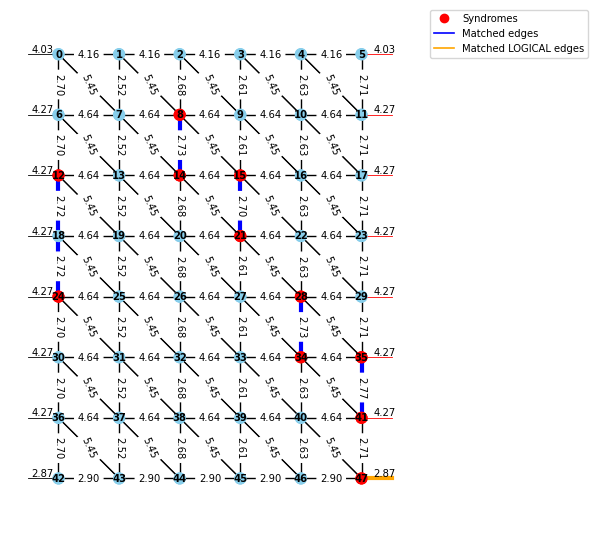

-----flat-----


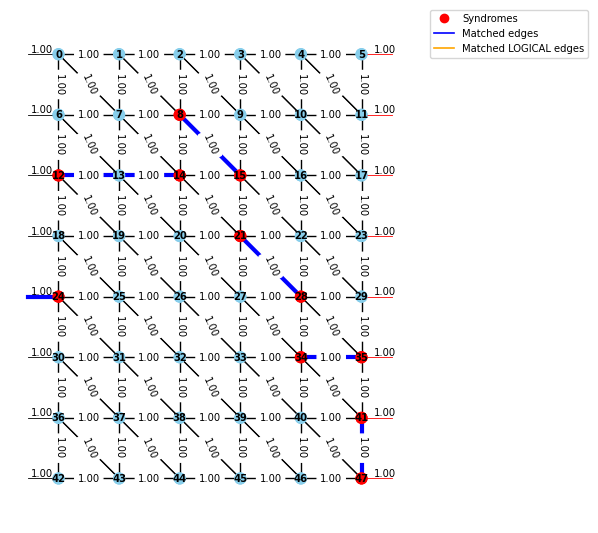

-----INFORMED-----


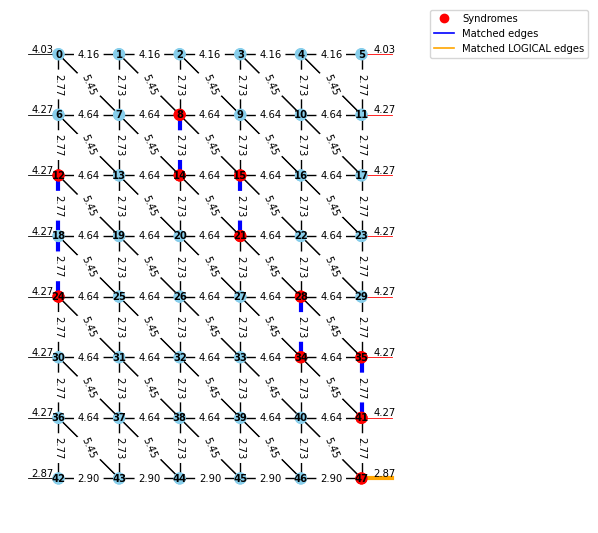

In [36]:
from soft_info import draw_matching_graph


index = 4320

fig_size = (4, 13)
scale_factor = 0.6

to_be_result = result
details = to_be_result.error_details[index]
print("-----IQ-----")
draw_matching_graph(matching=None, d=DISTANCE, T=ROUNDS, syndromes=details.detection_syndromes,
                        matched_edges=details.matched_edges, figsize=fig_size, scale_factor=scale_factor, edge_list=details.edges)

to_be_result = result_flat
details = to_be_result.error_details[index]
print("-----flat-----")
draw_matching_graph(matching=None, d=DISTANCE, T=ROUNDS, syndromes=details.detection_syndromes,
                        matched_edges=details.matched_edges, figsize=fig_size, scale_factor=scale_factor, edge_list=details.edges)

to_be_result = result_informed
details = to_be_result.error_details[index]
print("-----INFORMED-----")
draw_matching_graph(matching=None, d=DISTANCE, T=ROUNDS, syndromes=details.detection_syndromes,
                        matched_edges=details.matched_edges, figsize=fig_size, scale_factor=scale_factor, edge_list=details.edges)


In [13]:
print("indices that are in informed but not in IQ:")
informed_not_in_iq = sorted(set(result_informed.indices) - set(result.indices))
print(informed_not_in_iq)
print("indices that are in IQ but not in informed:")
iq_not_in_informed = sorted(set(result.indices) - set(result_informed.indices))
print(iq_not_in_informed)

print()

print("indices that are in IQ but not in flat:")
iq_not_in_flat = sorted(set(result.indices) - set(result_flat.indices))
print(iq_not_in_flat)
print("indices that are in flat but not in IQ:")
flat_not_in_iq = sorted(set(result_flat.indices) - set(result.indices))
print(flat_not_in_iq)



indices that are in informed but not in IQ:
[0, 1, 2, 3, 5, 6, 8, 11, 14, 18, 25, 27, 28, 31, 35, 36, 40, 44, 45, 46, 47, 51, 52, 53, 55, 56, 58, 61, 64, 70, 74, 76, 78, 79, 88, 94, 97, 100, 110, 114, 117, 121, 127, 132, 133, 135, 136, 144, 146, 149, 152, 156, 162, 163, 165, 166, 169, 171, 172, 174, 175, 176, 182, 187, 190, 193, 194, 205, 208, 211, 212, 213, 215, 216, 217, 218, 220, 222, 227, 230, 232, 235, 240, 245, 249, 254, 261, 268, 269, 271, 273, 274, 277, 278, 280, 281, 282, 284, 287, 288, 289, 294, 296, 297, 302, 304, 306, 307, 308, 313, 316, 325, 326, 330, 335, 336, 337, 339, 340, 341, 342, 347, 349, 359, 360, 362, 363, 373, 375, 379, 381, 383, 385, 388, 391, 392, 393, 398, 400, 404, 406, 409, 410, 413, 414, 417, 419, 420, 421, 422, 424, 428, 433, 434, 436, 438, 442, 444, 445, 446, 448, 449, 451, 456, 457, 463, 464, 473, 478, 480, 483, 484, 485, 487, 493, 494, 495, 505, 506, 508, 509, 516, 518, 527, 530, 532, 535, 536, 537, 539, 542, 546, 547, 550, 556, 561, 564, 566, 568, 569,

# Analyse specific shots

{'0000000 100101 000000 101010 000001 101000 010110 001101': 1}
-----IQ-----


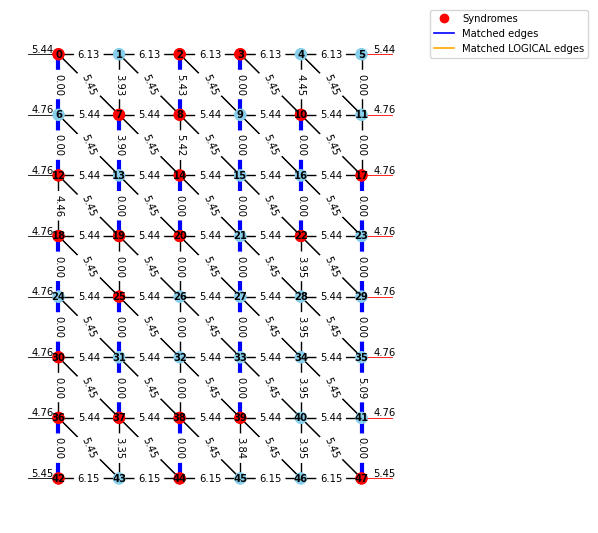

In [50]:
index = 64
IQ_data = extreme_IQ_data[index:index+1]

esult = cpp_soft_info.decode_IQ_shots(matching._matching_graph, IQ_data,
                                           ROUNDS, int(LOGICAL), _RESETS, simulator.qubit_mapping, simulator.grid_dict,
                                           simulator.processed_scaler_dict, p_data=-1, p_mixed=-1,
                                           common_measure=-1, _adv_probs=not _RESETS, _bimodal=_RESETS, merge_strategy = "replace", _detailed=True)


print(cpp_soft_info.get_counts(IQ_data, simulator.qubit_mapping, simulator.grid_dict, simulator.processed_scaler_dict, ROUNDS))



to_be_result = esult
details = to_be_result.error_details[0]
print("-----IQ-----")
draw_matching_graph(matching=None, d=DISTANCE, T=ROUNDS, syndromes=details.detection_syndromes,
                        matched_edges=details.matched_edges, figsize=fig_size, scale_factor=scale_factor, edge_list=details.edges)